In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from statistics import mode
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# imports raw csv: first row must contain time, x, y, z
df= pd.read_csv(r"C:\Users\jeong\Desktop\microbit (5).csv")

# instead of above line, use the below three lines if running code in google colab
# from google.colab import files
# uploaded = files.upload()
# df= pd.read_csv('stand_walk_run_golf_dribble.csv')

# asks for activities performed with commas in between
activities= input("Enter activities: ").split(",")

# adds activity tags to each timestamp in column "ADL". moves onto next activity every time there is a time gap > 1.0 sec.(data collection is every 0.1 sec)
index = 0
for i in range(0, df.shape[0]-1):
    df.loc[df.index[i], 'ADL'] = activities[index]
    if (df.iloc[(i+1),0]-df.iloc[i,0])>1.0:
        index+=1
df.loc[df.index[df.shape[0]-1], 'ADL'] = activities[index]

Enter activities: stand,walk,dribble,jj,golf


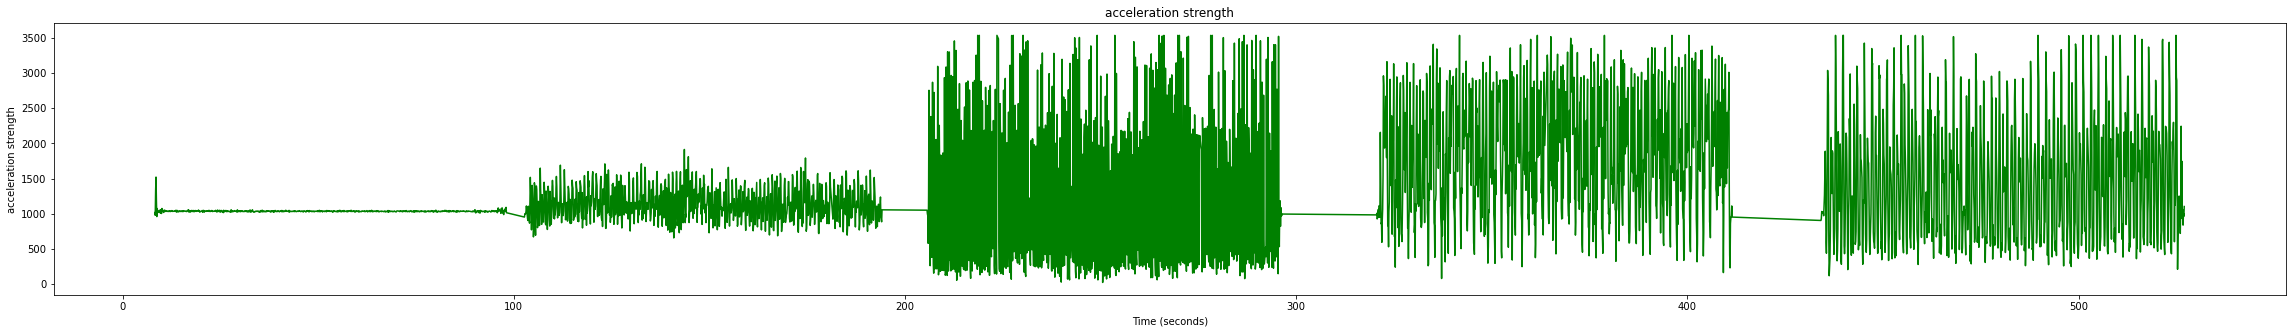

In [28]:
import matplotlib.pyplot as plt

def graph(data):
  t = data['Time (seconds)']
  s = data['s']

  plt.figure(figsize=(40,5))
  plt.xlabel("Time (seconds)")
  plt.ylabel("acceleration strength")
  plt.title("acceleration strength")

  plt.plot(t, s, color='g', label='acc_s')
  plt.show()

df2= pd.read_csv(r"C:\Users\jeong\Desktop\microbit (5).csv")
graph(df2)

In [29]:
df2

,Time (seconds),x,y,z,s
0,8.31,-148,580,-824,1018
1,8.33,-300,880,-308,979
2,8.43,-360,1272,-164,1332
3,8.53,-816,1284,16,1521
4,8.63,-468,1092,-84,1191
...,...,...,...,...,...
4493,526.60,292,24,-1016,1057
4494,526.70,308,28,-780,839
4495,526.80,208,8,-988,1009
4496,526.90,324,-28,-908,964


In [3]:
# preprocessing
x_list = []
y_list = []
z_list = []
train_labels = []

# creating windows of size window-size 19 with no overlap: each window is 1.9 sec.(window size is not 20 to avoid possible mode error) (microbit collects data every 100ms)
window_size = 19

for i in range(0, df.shape[0] - window_size):
    xs = df['x'].values[i: i + window_size]
    ys = df['y'].values[i: i + window_size]
    zs = df['z'].values[i: i + window_size]
    label = mode(df['ADL'][i: i + window_size])
    
    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)
    
processed_df = pd.DataFrame()

# 12 total features(4*3(x,y,z))
# mean
processed_df['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
processed_df['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
processed_df['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
processed_df['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
processed_df['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
processed_df['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# min
processed_df['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
processed_df['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
processed_df['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
processed_df['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
processed_df['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
processed_df['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

processed_df["ADL"] = train_labels

In [4]:
processed_df

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_min,y_min,z_min,x_max,y_max,z_max,ADL
0,-340.210526,989.052632,-97.894737,129.676350,139.821493,185.750794,-816,580,-824,-148,1284,16,stand
1,-351.157895,1010.315789,-57.684211,121.510347,101.453154,72.202240,-816,880,-308,-188,1284,16,stand
2,-354.526316,1014.947368,-42.105263,120.931198,97.322834,42.219844,-816,920,-164,-188,1284,16,stand
3,-354.315789,999.157895,-34.736842,120.924967,76.431781,31.039605,-816,920,-96,-188,1284,16,stand
4,-328.842105,982.315789,-36.842105,52.740939,36.782508,28.802893,-468,920,-96,-188,1092,4,stand
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4474,-375.789474,496.421053,-435.789474,759.605963,856.868123,950.507874,-2040,-544,-1720,472,2040,2040,golf
4475,-369.894737,526.315789,-540.000000,764.316130,829.519903,898.441223,-2040,-208,-1720,472,2040,2040,golf
4476,-333.684211,510.526316,-643.368421,779.133463,835.974525,801.943180,-2040,-208,-1720,472,2040,2040,golf
4477,-215.368421,403.578947,-802.736842,674.726628,759.991019,494.968456,-2040,-208,-1720,472,2040,552,golf


In [25]:
# splits dataframe
X = pd.DataFrame(processed_df.drop(['ADL'],axis=1))
Y = processed_df.ADL.values.astype(object)

encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(Y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)


In [26]:
# training the model: SVC with linear kernel, ovo
svc = SVC(kernel="linear", C=100.0, decision_function_shape='ovo') 
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)

print('Model accuracy score:', accuracy_score(y_test, y_pred))

Model accuracy score: 0.9970238095238095


In [7]:
# dictionary of classes
list(encoder.inverse_transform([0,1,2,3,4]))

['dribble', 'golf', 'jj', 'stand', 'walk']

In [19]:
coef=svc.coef_
k=svc.intercept_

In [20]:
coef

array([[-1.25559259e+00, -3.64287262e+00,  6.23931121e-01,
        -2.98794925e+00,  4.63243881e-01,  1.51791457e+01,
         3.32257870e+00, -1.65215245e+00, -2.62031387e+00,
        -4.54590336e+00,  2.83757446e-01, -9.23485276e+00],
       [-4.45286659e-01, -2.44126116e+00, -2.10854371e-02,
        -1.56872540e+00,  2.29116992e+00,  1.27184480e+00,
        -4.79484458e-01,  1.00925036e+00, -9.80969787e-01,
        -5.28261302e-01, -7.33210855e-01, -5.75732606e-01],
       [ 4.71966984e-01, -4.95658490e-01, -2.72628566e-01,
         1.06756085e-01,  2.37943589e-01,  1.91411055e-01,
        -1.16208288e-01, -4.21438699e-01, -1.91337364e-01,
         1.92180099e-01, -1.13539977e-02,  2.01927781e-01],
       [ 1.28446274e+00, -2.81572444e-01, -1.74115394e-01,
        -4.48268439e-03,  5.16905644e-01,  1.49862955e+00,
        -2.84969515e-01, -1.72261488e+00, -1.55150410e+00,
        -1.95601285e-01, -6.43299828e-01, -1.69429445e-01],
       [ 1.88408306e+00, -1.53047884e+00,  4.0822534

In [21]:
k

array([-9.14427219e+00, -3.28832520e+00,  9.74994008e-03, -1.16838421e+00,
       -1.14273751e+00,  6.73513776e-01,  3.55781141e-01,  6.52481403e-01,
        9.01483623e-01, -2.21033551e+01])

In [18]:
import numpy
a = numpy.asarray(coef)
numpy.savetxt("coef.csv", a, delimiter=",")

In [11]:
k.shape

(10,)

In [12]:
# function that predicts class of newdata(array with 12 elements)
def predict(newdata):
    votingPool= []
    for i in range(10):
        votingPool.append(np.sign(svc.coef_[i].dot(newdata) + svc.intercept_[i]))
    
    currentIndex=0
    votes=[]
    for i in range(len(activities)-1):
        for j in range(i+1,len(activities)):
            if votingPool[currentIndex]>0:
                votes.append(i)
            else:
                votes.append(j)            
            currentIndex+=1
    print(mode(votes), encoder.inverse_transform([mode(votes)]))

In [36]:
predict(X_test[132])

2 ['jj']


In [35]:
encoder.inverse_transform(svc.predict(X_test[132:133]))

array(['jj'], dtype=object)